# NYC Taxi Trip Data Cleaning and Feature Preparation

This notebook performs data cleaning, exploratory analysis, and feature preprocessing on the 2022 NYC Taxi dataset. The cleaned data is saved for further use in distributed training.

---

## Workflow Outline

1. Load raw data
2. Handle missing values
3. Convert datetime (`pickup_ts`, `dropoff_ts`) to `trip_duration`
4. Filter out non-positive values (`trip_duration`, `trip_distance`, `passenger_count`, `extra`, `total_amount`)
5. Detect and remove outliers
6. Normalize continuous features
7. Encode categorical features:
   - One-hot encode low-cardinality features (`RatecodeID`, `payment_type`)
   - Normalization for high-cardinality features (`PULocationID`, `DOLocationID`)
8. Save cleaned dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load data from csv file
df = pd.read_csv('nytaxi2022.csv')

/var/folders/8p/3d218n_n0_d_80_262nzz8rh0000gn/T/ipykernel_40794/1126275083.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nytaxi2022.csv')


In [3]:
# Inspect data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39656098 entries, 0 to 39656097
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(12), int64(4), object(3)
memory usage: 5.6+ GB


In [4]:
# Inspect data head
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,01/01/2022 12:35:40 AM,01/01/2022 12:53:29 AM,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,01/01/2022 12:33:43 AM,01/01/2022 12:42:07 AM,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,01/01/2022 12:53:21 AM,01/01/2022 01:02:19 AM,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,01/01/2022 12:25:21 AM,01/01/2022 12:35:23 AM,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,01/01/2022 12:36:48 AM,01/01/2022 01:14:20 AM,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
# Check for missing values
df.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1368303
trip_distance                  0
RatecodeID               1368303
store_and_fwd_flag       1368303
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1368303
airport_fee              1368303
dtype: int64

In [6]:
# Drop rows with missing values
df.dropna()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,01/01/2022 12:35:40 AM,01/01/2022 12:53:29 AM,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,01/01/2022 12:33:43 AM,01/01/2022 12:42:07 AM,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,01/01/2022 12:53:21 AM,01/01/2022 01:02:19 AM,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,01/01/2022 12:25:21 AM,01/01/2022 12:35:23 AM,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,01/01/2022 12:36:48 AM,01/01/2022 01:14:20 AM,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39529630,2,12/31/2022 11:36:15 PM,12/31/2022 11:52:36 PM,1.0,4.02,1.0,N,233,7,1,19.8,1.0,0.5,4.96,0.0,1.0,29.76,2.5,0.0
39529631,2,12/31/2022 11:09:34 PM,12/31/2022 11:17:46 PM,1.0,1.12,1.0,N,161,142,1,8.6,1.0,0.5,0.00,0.0,1.0,13.60,2.5,0.0
39529632,2,12/31/2022 11:39:06 PM,12/31/2022 11:51:55 PM,1.0,1.81,1.0,N,161,141,1,12.8,1.0,0.5,4.45,0.0,1.0,22.25,2.5,0.0
39529633,2,12/31/2022 11:09:37 PM,12/31/2022 11:23:07 PM,1.0,2.35,1.0,N,229,142,2,14.9,1.0,0.5,0.00,0.0,1.0,19.90,2.5,0.0


In [7]:
# Check for duplicates
df.duplicated().sum()

np.int64(1)

In [8]:
# Drop duplicate rows
df.drop_duplicates()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,01/01/2022 12:35:40 AM,01/01/2022 12:53:29 AM,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,01/01/2022 12:33:43 AM,01/01/2022 12:42:07 AM,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,01/01/2022 12:53:21 AM,01/01/2022 01:02:19 AM,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,01/01/2022 12:25:21 AM,01/01/2022 12:35:23 AM,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,01/01/2022 12:36:48 AM,01/01/2022 01:14:20 AM,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39656093,2,12/31/2022 11:46:00 PM,01/01/2023 12:11:00 AM,NaN,11.56,NaN,NaN,16,36,0,39.55,0.0,0.5,8.21,0.0,1.0,49.26,NaN,NaN
39656094,2,12/31/2022 11:13:24 PM,12/31/2022 11:29:08 PM,NaN,5.06,NaN,NaN,75,50,0,26.23,0.0,0.5,0.00,0.0,1.0,30.23,NaN,NaN
39656095,2,12/31/2022 11:00:49 PM,12/31/2022 11:26:57 PM,NaN,13.35,NaN,NaN,168,197,0,47.73,0.0,0.5,9.85,0.0,1.0,59.08,NaN,NaN
39656096,1,12/31/2022 11:02:50 PM,12/31/2022 11:16:05 PM,NaN,0.00,NaN,NaN,238,116,0,12.74,0.0,0.5,0.00,0.0,1.0,16.74,NaN,NaN


In [9]:
# Convert datetime columns (pickup_ts & dropoff_ts) to timestamps (in seconds)
df['pickup_ts'] = pd.to_datetime(df['tpep_pickup_datetime']).astype(np.int64) // 10**9
df['dropoff_ts'] = pd.to_datetime(df['tpep_dropoff_datetime']).astype(np.int64) // 10**9

# Calculate trip duration in minutes
df['trip_duration'] = (df['dropoff_ts'] - df['pickup_ts']) / 60.0

/var/folders/8p/3d218n_n0_d_80_262nzz8rh0000gn/T/ipykernel_40794/767051370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_ts'] = pd.to_datetime(df['tpep_pickup_datetime']).astype(np.int64) // 10**9
/var/folders/8p/3d218n_n0_d_80_262nzz8rh0000gn/T/ipykernel_40794/767051370.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dropoff_ts'] = pd.to_datetime(df['tpep_dropoff_datetime']).astype(np.int64) // 10**9


In [10]:
# Define selected columns
selected_cols = [
    "trip_duration",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "extra",
    "total_amount"
]

df = df[selected_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39656098 entries, 0 to 39656097
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   trip_duration    float64
 1   passenger_count  float64
 2   trip_distance    float64
 3   RatecodeID       float64
 4   PULocationID     int64  
 5   DOLocationID     int64  
 6   payment_type     int64  
 7   extra            float64
 8   total_amount     float64
dtypes: float64(6), int64(3)
memory usage: 2.7 GB


In [11]:
# Filter out rows with non-positive values in columns (trip_duration, trip_distance, passenger_count, extra, total_amount)
df = df[
    (df['trip_duration'] > 0) &
    (df['trip_distance'] > 0) &
    (df['passenger_count'] > 0) &
    (df['extra'] >= 0) &
    (df['total_amount'] > 0)
]

df.shape

(36816758, 9)

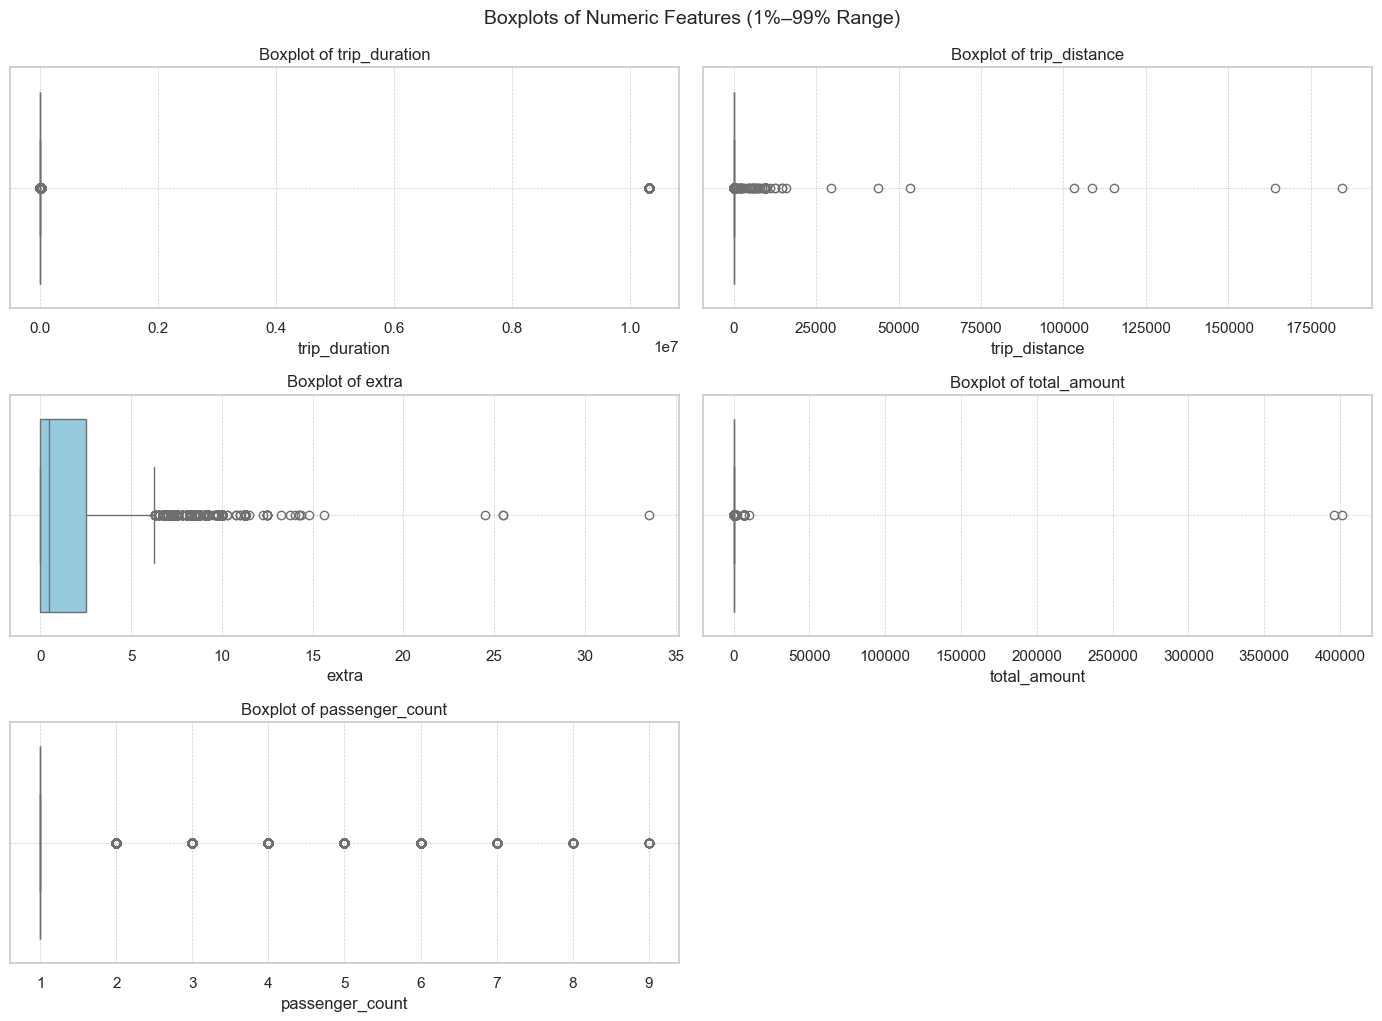

In [12]:
# Plot boxplots for numeric features to identify outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set_theme(style="whitegrid")

# Numeric columns to check for outliers
numeric_cols = ["trip_duration", "trip_distance", "extra", "total_amount", "passenger_count"]

# Set up a grid of plots
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
axes = axes.flatten()

# Plot boxplots
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].grid(True, linestyle="--", linewidth=0.5)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots of Numeric Features (1%–99% Range)", fontsize=14, y=1.02)
plt.show()

In [13]:
# Set quantile thresholds for outlier detection
lower_bounds = df.quantile(0.01)
upper_bounds = df.quantile(0.99)

# Remove outliers based on 1st and 99th percentiles
for col in numeric_cols:
    df = df[(df[col] >= lower_bounds[col]) & (df[col] <= upper_bounds[col])]
    
df.shape

(35169042, 9)

In [14]:
# Normalize numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

,trip_duration,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount
0,0.273193,0.600719,0.165635,1.0,142,236,1,1.681141,0.138560
1,-0.630028,-0.449011,-0.297847,1.0,236,42,1,-0.422256,-0.516831
2,-0.575675,-0.449011,-0.605927,1.0,166,166,1,-0.422256,-0.724435
3,-0.473363,-0.449011,-0.573211,1.0,114,68,2,-0.422256,-0.630483
4,2.164361,-0.449011,0.301954,1.0,68,163,1,-0.422256,0.771222


In [15]:
# One-hot encode low cardinality categorical features (RatecodeID, payment_type)
low_cardinality_cols = ['RatecodeID', 'payment_type']
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)
df.head()

,trip_duration,passenger_count,trip_distance,PULocationID,DOLocationID,extra,total_amount,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_2,payment_type_3,payment_type_4,payment_type_5
0,0.273193,0.600719,0.165635,142,236,1.681141,0.138560,False,False,False,False,False,False,False,False,False,False
1,-0.630028,-0.449011,-0.297847,236,42,-0.422256,-0.516831,False,False,False,False,False,False,False,False,False,False
2,-0.575675,-0.449011,-0.605927,166,166,-0.422256,-0.724435,False,False,False,False,False,False,False,False,False,False
3,-0.473363,-0.449011,-0.573211,114,68,-0.422256,-0.630483,False,False,False,False,False,False,True,False,False,False
4,2.164361,-0.449011,0.301954,68,163,-0.422256,0.771222,False,False,False,False,False,False,False,False,False,False


In [16]:
# Normalization high cardinality categorical features (PULocationID, DOLocationID)
high_cardinality_cols = ['PULocationID', 'DOLocationID']
df[high_cardinality_cols] = scaler.fit_transform(df[high_cardinality_cols])
df.head()

,trip_duration,passenger_count,trip_distance,PULocationID,DOLocationID,extra,total_amount,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_2,payment_type_3,payment_type_4,payment_type_5
0,0.273193,0.600719,0.165635,-0.363845,1.043918,1.681141,0.138560,False,False,False,False,False,False,False,False,False,False
1,-0.630028,-0.449011,-0.297847,1.082318,-1.742352,-0.422256,-0.516831,False,False,False,False,False,False,False,False,False,False
2,-0.575675,-0.449011,-0.605927,0.005388,0.038563,-0.422256,-0.724435,False,False,False,False,False,False,False,False,False,False
3,-0.473363,-0.449011,-0.573211,-0.794617,-1.368934,-0.422256,-0.630483,False,False,False,False,False,False,True,False,False,False
4,2.164361,-0.449011,0.301954,-1.502314,-0.004523,-0.422256,0.771222,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Save cleaned data to a new csv file
df.to_csv('nytaxi2022_cleaned.csv', index=False)

: 